In [8]:
from scipy import ndimage, misc
from collections import Counter
from core.vggnet import Vgg19
from core.utils import *
from imageio import imread
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import json


# def _process_caption_data(caption_file, image_dir, max_length):
#     with open(caption_file) as f:
#         caption_data = json.load(f)

#     # id_to_filename is a dictionary such as {image_id: filename]} 
#     id_to_filename = {image['id']: image['file_name'] for image in caption_data['images']}

#     # data is a list of dictionary which contains 'captions', 'file_name' and 'image_id' as key.
#     data = []
#     for annotation in caption_data['annotations']:
#         image_id = annotation['image_id']
#         annotation['file_name'] = os.path.join(image_dir, id_to_filename[image_id])
#         data += [annotation]
    
#     # convert to pandas dataframe (for later visualization or debugging)
#     caption_data = pd.DataFrame.from_dict(data)
#     del caption_data['id']
#     caption_data.sort_values(by='image_id', inplace=True)
#     caption_data = caption_data.reset_index(drop=True)
    
#     del_idx = []
#     for i, caption in enumerate(caption_data['caption']):
#         caption = caption.replace('.','').replace(',','').replace("'","").replace('"','')
#         caption = caption.replace('&','and').replace('(','').replace(")","").replace('-',' ')
#         caption = " ".join(caption.split())  # replace multiple spaces
        
#         caption_data.set_value(i, 'caption', caption.lower())
#         if len(caption.split(" ")) > max_length:
#             del_idx.append(i)
    
#     # delete captions if size is larger than max_length
#     print ("The number of captions before deletion: %d" %len(caption_data))
#     caption_data = caption_data.drop(caption_data.index[del_idx])
#     caption_data = caption_data.reset_index(drop=True)
#     print ("The number of captions after deletion: %d" %len(caption_data))
#     return caption_data


# def _build_vocab(annotations, threshold=1):
#     counter = Counter()
#     max_len = 0
#     for i, caption in enumerate(annotations['caption']):
#         words = caption.split(' ') # caption contrains only lower-case words
#         for w in words:
#             counter[w] +=1
        
#         if len(caption.split(" ")) > max_len:
#             max_len = len(caption.split(" "))

#     vocab = [word for word in counter if counter[word] >= threshold]
#     print ('Filtered %d words to %d words with word count threshold %d.' % (len(counter), len(vocab), threshold))

#     word_to_idx = {u'<NULL>': 0, u'<START>': 1, u'<END>': 2}
#     idx = 3
#     for word in vocab:
#         word_to_idx[word] = idx
#         idx += 1
#     print ("Max length of caption: ", max_len)
#     return word_to_idx


# def _build_caption_vector(annotations, word_to_idx, max_length=15):
#     n_examples = len(annotations)
#     captions = np.ndarray((n_examples,max_length+2)).astype(np.int32)   

#     for i, caption in enumerate(annotations['caption']):
#         words = caption.split(" ") # caption contrains only lower-case words
#         cap_vec = []
#         cap_vec.append(word_to_idx['<START>'])
#         for word in words:
#             if word in word_to_idx:
#                 cap_vec.append(word_to_idx[word])
#         cap_vec.append(word_to_idx['<END>'])
        
#         # pad short caption with the special null token '<NULL>' to make it fixed-size vector
#         if len(cap_vec) < (max_length + 2):
#             for j in range(max_length + 2 - len(cap_vec)):
#                 cap_vec.append(word_to_idx['<NULL>']) 
        
#         captions[i, :] = np.asarray(cap_vec)
#     print ("Finished building caption vectors")
#     return captions


def _build_file_names(annotations):
    image_file_names = []
    id_to_idx = {}
    idx = 0
    image_ids = annotations['image_id']
    file_names = annotations['file_name']
    for image_id, file_name in zip(image_ids, file_names):
        if not image_id in id_to_idx:
            id_to_idx[image_id] = idx
            image_file_names.append(file_name)
            idx += 1

    file_names = np.asarray(image_file_names)
    return file_names, id_to_idx


def _build_image_idxs(annotations, id_to_idx):
    image_idxs = np.ndarray(len(annotations), dtype=np.int32)
    image_ids = annotations['image_id']
    for i, image_id in enumerate(image_ids):
        image_idxs[i] = id_to_idx[image_id]
    return image_idxs


def main():
    # batch size for extracting feature vectors from vggnet.
    batch_size = 100
    # maximum length of caption(number of word). if caption is longer than max_length, deleted.  
    max_length = 15
    # if word occurs less than word_count_threshold in training dataset, the word index is special unknown token.
    word_count_threshold = 1
    # vgg model path 
    vgg_model_path = './data/imagenet-vgg-verydeep-19.mat'

    caption_file = 'data/annotations/captions_train2014.json'
    image_dir = 'image/%2014_resized/'

    # about 80000 images and 400000 captions for train dataset
    
    test_dataset = _process_caption_data(caption_file='data/annotations/captions_test2014.json',
                                        image_dir='../../lab14/showntell/show-attend-and-tell-tensorflow/image/test2014_resize',
                                        max_length=max_length)
    
    
    
    # about 4000 images and 20000 captions for val / test dataset
    print ('Finished processing caption data')

    save_pickle(test_dataset, 'data/test/test.annotations.pkl')

    for split in ['test']:
        annotations = load_pickle('./data/%s/%s.annotations.pkl' % (split, split))

        if split == 'train':
            word_to_idx = _build_vocab(annotations=annotations, threshold=word_count_threshold)
            save_pickle(word_to_idx, './data/%s/word_to_idx.pkl' % split)
        
        captions = _build_caption_vector(annotations=annotations, word_to_idx=word_to_idx, max_length=max_length)
        save_pickle(captions, './data/%s/%s.captions.pkl' % (split, split))

        file_names, id_to_idx = _build_file_names(annotations)
        save_pickle(file_names, './data/%s/%s.file.names.pkl' % (split, split))

        image_idxs = _build_image_idxs(annotations, id_to_idx)
        save_pickle(image_idxs, './data/%s/%s.image.idxs.pkl' % (split, split))

        # prepare reference captions to compute bleu scores later
        image_ids = {}
        feature_to_captions = {}
        i = -1
        for caption, image_id in zip(annotations['caption'], annotations['image_id']):
            if not image_id in image_ids:
                image_ids[image_id] = 0
                i += 1
                feature_to_captions[i] = []
            feature_to_captions[i].append(caption.lower() + ' .')
        save_pickle(feature_to_captions, './data/%s/%s.references.pkl' % (split, split))
        print ("Finished building %s caption dataset" %split)

    # extract conv5_3 feature vectors
    vggnet = Vgg19(vgg_model_path)
    vggnet.build()
    with tf.Session() as sess:
        tf.initialize_all_variables().run()
        for split in ['test']:
            anno_path = './data/%s/%s.annotations.pkl' % (split, split)
            save_path = './data/%s/%s.features.hkl' % (split, split)
            annotations = load_pickle(anno_path)
            image_path = list(annotations['file_name'].unique())
            n_examples = len(image_path)

            all_feats = np.ndarray([n_examples, 196, 512], dtype=np.float32)

            for start, end in zip(range(0, n_examples, batch_size),
                                  range(batch_size, n_examples + batch_size, batch_size)):
                image_batch_file = image_path[start:end]
                image_batch = np.array(list(map(lambda x: imread(x, pilmode='RGB'), image_batch_file))).astype( np.float32)
                feats = sess.run(vggnet.features, feed_dict={vggnet.images: image_batch})
                all_feats[start:end, :] = feats
                print ("Processed %d %s features.." % (end, split))

            # use hickle to save huge feature vectors
            hickle.dump(all_feats, save_path)
            print ("Saved %s.." % (save_path))


if __name__ == "__main__":
    main()


KeyError: 'annotations'

In [1]:
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from core.solver import CaptioningSolver
from core.model import CaptionGenerator
from core.utils import load_coco_data
from core.bleu import evaluate

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
data = load_coco_data(data_path='./data', split='val')
with open('./data/train/word_to_idx.pkl', 'rb') as f:
    word_to_idx = pickle.load(f)

features <class 'numpy.ndarray'> (4052, 196, 512) float32
file_names <class 'numpy.ndarray'> (4052,) <U51
captions <class 'numpy.ndarray'> (19589, 17) int32
image_idxs <class 'numpy.ndarray'> (19589,) int32
Elapse time: 6.13


In [3]:
model = CaptionGenerator(word_to_idx, dim_feature=[196, 512], dim_embed=512,
                                   dim_hidden=1024, n_time_step=16, prev2out=True, 
                                             ctx2out=True, alpha_c=1.0, selector=True, dropout=True)

W0927 11:23:24.670423 139627296552704 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0927 11:23:24.671696 139627296552704 deprecation_wrapper.py:119] From /home/lab21/show-attend-and-tell-tensorflow/core/model.py:56: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [4]:
solver = CaptioningSolver(model, data, data, n_epochs=15, batch_size=128, update_rule='adam',
                                      learning_rate=0.0025, print_every=2000, save_every=1, image_path='./image/val2014_resize',
                                pretrained_model=None, model_path='./model/lstm', test_model='./model/lstm/model-48',
                                 print_bleu=False, log_path='./log/')

W0927 11:23:31.211093 139627296552704 deprecation_wrapper.py:119] From /home/lab21/show-attend-and-tell-tensorflow/core/solver.py:55: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



W0927 11:23:35.146984 139627296552704 deprecation_wrapper.py:119] From /home/lab21/show-attend-and-tell-tensorflow/core/model.py:138: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0927 11:23:35.172547 139627296552704 deprecation_wrapper.py:119] From /home/lab21/show-attend-and-tell-tensorflow/core/model.py:60: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0927 11:23:35.176539 139627296552704 deprecation_wrapper.py:119] From /home/lab21/show-attend-and-tell-tensorflow/core/model.py:63: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0927 11:23:35.215825 139627296552704 deprecation.py:323] From /home/lab21/show-attend-and-tell-tensorflow/core/model.py:195: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be

Sampled Caption: a bunch of oranges and oranges on a table .


/home/lab21/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


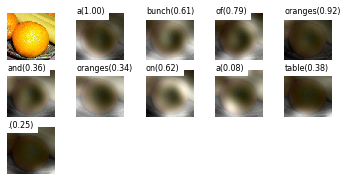

Sampled Caption: a man and a woman are eating at the table .


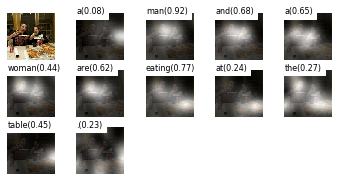

Sampled Caption: a large black vase filled with white flowers .


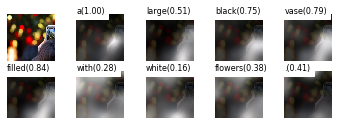

Sampled Caption: a giraffe standing in the middle of a field .


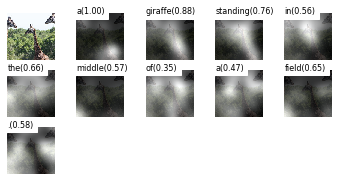

Sampled Caption: a cat laying on top of a sink near a mouse .


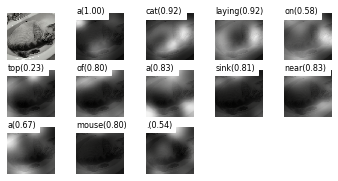

Sampled Caption: a pair of scissors is flying a piece of fruit .


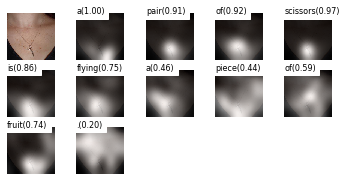

Sampled Caption: a woman is preparing food bite into a plate .


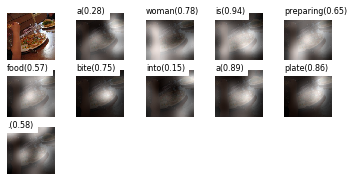

Sampled Caption: a group of people standing around a large group of people .


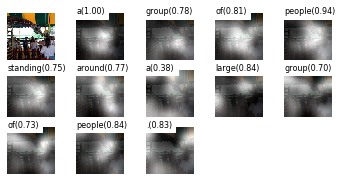

Sampled Caption: a bus parked next to a building near a bus .


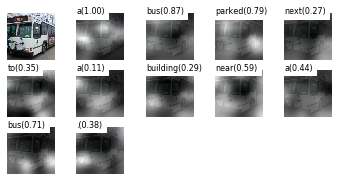

Sampled Caption: a man is snowboarding down a hill while standing on a snow covered hillside .


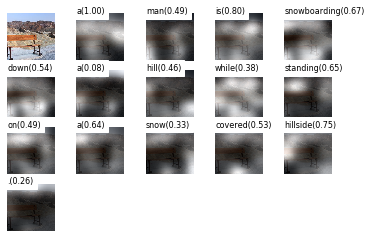

Saved ./data/val/val.candidate.captions.pkl..


In [5]:
solver.test(data, split='val')

In [6]:
test = load_coco_data(data_path='./data', split='test')

features <class 'numpy.ndarray'> (4048, 196, 512) float32
file_names <class 'numpy.ndarray'> (4048,) <U51
captions <class 'numpy.ndarray'> (19589, 17) int32
image_idxs <class 'numpy.ndarray'> (19589,) int32
Elapse time: 5.89


Sampled Caption: a man standing in the middle of a street next to a busy traffic light .


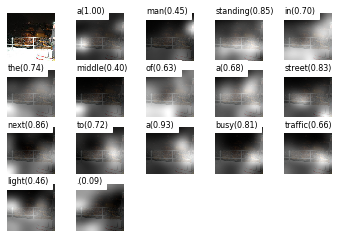

Sampled Caption: a black and white picture of a clock tower with a clock on it .


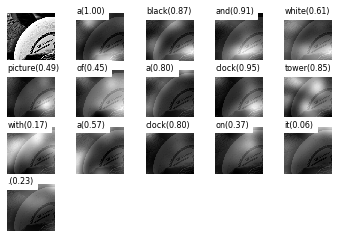

Sampled Caption: a giraffe standing in the middle of a field .


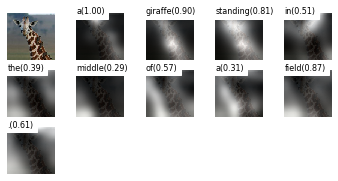

Sampled Caption: a group of young men standing next to each other holding wii controllers .


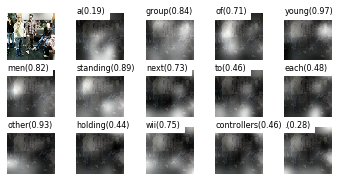

Sampled Caption: a man is riding a bench while another watches .


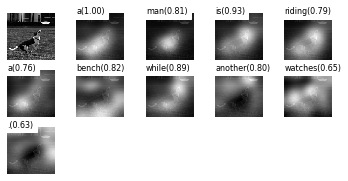

Sampled Caption: a dog laying on the floor next to a blue vase .


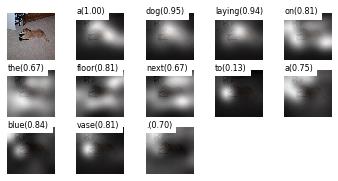

Sampled Caption: a woman holding a tennis racquet on a tennis court .


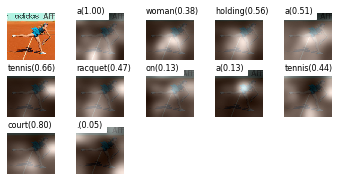

Sampled Caption: a young man is swinging at a baseball bat .


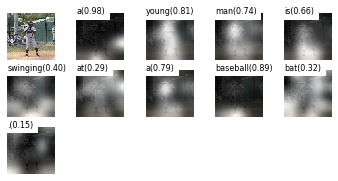

Sampled Caption: a man with a beard and a black and white tie .


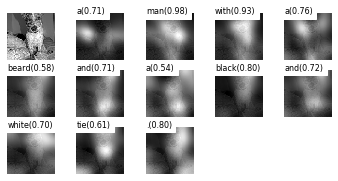

Sampled Caption: a red red bus driving down a street corner .


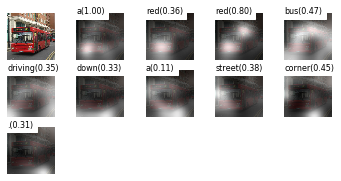

Saved ./data/test/test.candidate.captions.pkl..


In [7]:
tf.get_variable_scope().reuse_variables()
solver.test(test, split='test')

In [8]:
evaluate(data_path='./data', split='val')

{'testlen': 45149, 'reflen': 44227, 'guess': [45149, 41097, 37045, 32993], 'correct': [27077, 9684, 3573, 1414]}
ratio: 1.0208469939177196
Bleu_1:	 0.5997253538284215
Bleu_2:	 0.3759226857947886
Bleu_3:	 0.23887287077283342
Bleu_4:	 0.1554647820375394
METEOR:	 0.19400368289113804
ROUGE_L: 0.4765594301685249
CIDEr:	 0.5139166454732091


In [9]:
evaluate(data_path='./data', split='test')

{'testlen': 45391, 'reflen': 44314, 'guess': [45391, 41343, 37295, 33247], 'correct': [27106, 9602, 3555, 1407]}
ratio: 1.024303831746152
Bleu_1:	 0.5971668392412461
Bleu_2:	 0.37241545767465245
Bleu_3:	 0.23645479771029382
Bleu_4:	 0.15379651915268364
METEOR:	 0.19344419423653644
ROUGE_L: 0.4728898824089311
CIDEr:	 0.49777018152394503
